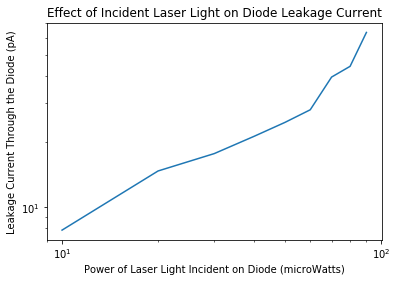

In [86]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy import random
import time

def calc(EHP_gen_num):
    numTSteps = 2000 # Number of time steps
    N = 100 # Number of positions / electric field sheets

    initialCC = 2000 # Inital Number of charge carriers for each holes, Na, Nd, and electrons
    dt = 5.88 * 10 ** (-14) # Time step
    dx = 2.0 * 10 ** (-8) # Position step
    A = 1.0 * 10 ** (-11) # Area of PN-junction interface
    N_a = initialCC
    N_d = initialCC

    holes_init = initialCC
    elecs_init = initialCC

    min_carriers = 2 # minority carrier concentration

    mobility_p = 0.04 # mu value for hole
    mobility_n = 0.13 # mu value for electron

    eps_s = 12 * 8.85 * 10 ** (-12)
    eC = 1.6 * 10 ** (-19)

    E_0 = eC / (eps_s * A)
    thermal_voltage = 0.02586

    c1_p = mobility_p * E_0 * dt / (2 * dx)
    c2_p = (thermal_voltage * mobility_p) * dt / (dx ** 2) 

    c1_n = mobility_n * E_0 * dt / (2 * dx)
    c2_n = (thermal_voltage * mobility_n) * dt / (dx ** 2)

    Na = np.concatenate(((-1) * np.ones(N / 2) * N_a, np.zeros(N / 2)))
    Nd = np.concatenate((np.zeros(N / 2), np.ones(N / 2) * N_d))

    holes = np.concatenate((np.ones(N / 2) * holes_init, np.ones(N / 2) * min_carriers))
    elecs = np.concatenate((np.ones(N / 2) * min_carriers, np.ones(N / 2) * elecs_init))

    E = np.zeros(N)
    r_holes = np.zeros(N)
    r_elecs = np.zeros(N)
    l_holes = np.zeros(N)
    l_elecs = np.zeros(N)

    holes_tot = np.zeros(N)
    elecs_tot = np.zeros(N)

    E_tot = np.zeros(N)

    loop = 200

    # 2. Begin Simulation 

    for n in range(numTSteps): # Over Time
        temporaryH = np.zeros(N)
        temporaryE = np.zeros(N)
        for i in range(N): # Over Position
            #Determine Electric Field at Position i (External Voltage will be accounted for by adding another term)
            if i == 0:
                E[i] = (-1) * np.sum(holes[1:N] - elecs[1:N] + Na[1:N] + Nd[1:N]) / 2
            elif i == (N - 1): 
                E[i] = np.sum(holes[0:N-1] - elecs[0:N-1] + Na[0:N-1] + Nd[0:N-1]) / 2
            else:
                pos = range(0, i)
                neg = range(i + 1, N)

                pos_field = np.sum(holes[pos] - elecs[pos] + Na[pos] + Nd[pos])
                neg_field = np.sum(holes[neg] - elecs[neg] + Na[neg] + Nd[neg])

                E[i] = (pos_field - neg_field) / 2; 

            # Calculate probabilities of carrier motion 
            r_holes[i] = E[i] * c1_p + c2_p
            l_holes[i] = (-1) * E[i] * c1_p + c2_p
            r_elecs[i] = (-1) * E[i] * c1_n + c2_n
            l_elecs[i] = E[i] * c1_n + c2_n
            
            # Move the holes 
            numH = holes[i]
            numRight = 0
            numLeft = 0
            numStay = 0
            


            if r_holes[i] < 0:
                numRight = 0 
            elif r_holes[i] > 1: 
                numRight = numH
            else:
                numRight = int(r_holes[i] * numH)

            if l_holes[i] < 0:
                numLeft = 0 
            elif l_holes[i] > 1: 
                numLeft = numH
            else:
                numLeft = int(l_holes[i] * numH)

            numStay = numH - numRight - numLeft
    

            if i == 0:
                temporaryH[1] += numRight
                temporaryH[0] += numStay + numLeft

            elif i == (N - 1):
                temporaryH[N-1] += numStay + numRight
                temporaryH[N-2] += numLeft

            else:
                temporaryH[i] += numStay
                temporaryH[i - 1] += numLeft
                temporaryH[i + 1] += numRight

            # Move the electrons
            numE = elecs[i]
            numRight = 0
            numLeft = 0
            numStay = 0

            if r_elecs[i] < 0:
                numRight = 0 
            elif r_elecs[i] > 1: 
                numRight = numE
            else:
                numRight = int(r_elecs[i] * numE)

            if l_elecs[i] < 0:
                numLeft = 0 
            elif l_elecs[i] > 1: 
                numLeft = numE
            else:
                numLeft = int(l_elecs[i] * numE)


            numStay = numE - numRight - numLeft
            if i == 0:
                temporaryE[1] += numRight
                temporaryE[0] += numStay + numLeft

            elif i == (N - 1):
                temporaryE[N-1] += numStay + numRight
                temporaryE[N-2] += numLeft

            else:
                temporaryE[i] += numStay
                temporaryE[i - 1] += numLeft
                temporaryE[i + 1] += numRight

        # Update carrier distribution
        holes = temporaryH
        elecs = temporaryE

        # EHP Generation by EM Stimulation
        depletion_right = 54
        depletion_left = 46


        for i in range(EHP_gen_num):
            x = random.randint(depletion_left, depletion_right)
            holes[x - 1] += 1
            elecs[x - 1] += 1
            
        for step in range(int(EHP_gen_num * 0.8)):
            sample = range(N)
            # [sample.remove(i) for i in range(49 - 4, 49 + 4 + 1)]
            place = random.choice(sample)
            holes[place] -= 1
            elecs[place] -= 1

        if n > (numTSteps - loop): # Averaging distribution over time
            holes_tot += holes
            elecs_tot += elecs
            E_tot += E

    holes_tot = holes_tot / loop
    elecs_tot = elecs_tot / loop
    E_tot = E_tot / loop
    tot = holes_tot - elecs_tot + Nd + Na
    
    sum = 0
    voltArray = []

    for i in range(N):
        sum += E_tot[i] * dx * E_0
        voltArray.append((-1) * sum)

    voltage = (voltArray[N-1] - voltArray[0])
    
    dif = math.sqrt((2 * eps_s * voltage) / eC * (5 * 10 ** (-23))) / dx

    Q_n = 0
    depletion_left = int(49 - dif)
    for i in range(depletion_left):
        Q_n += elecs[i]

    Q_p = 0 
    depletion_right = int(49 + dif)
    for i in range(depletion_right, N): 
        Q_p += holes[i]

    tau_p = 10 ** (-4) # Will adjust value to experimentally determined values
    tau_n = 10 ** (-4)

    I_tot = (Q_p / tau_p + Q_n / tau_n) * eC
    
    
    return(I_tot)

PValues = np.arange(0.00001, 0.0001, 0.00001)
calcValues = [] 
currentVals = []

import scipy.integrate as integrate

def integrand(x, Gs, alpha):
    return alpha * Gs * math.exp(-1 * alpha * x)

for Power in PValues:
    alpha = 2.55 * 10 ** 6
    eta = 1
    lambdaVal = 0.45 * 10 ** (-6)
    h = 6.626 * 10 ** (-34)
    c = 3 * 10 ** (8)
    A = 1 * 10 ** (-11)
    L = math.sqrt(A)
    P = Power
    Gs = eta * alpha * lambdaVal * P / (h * c * 8 * dx * L)
    
    G = integrate.quad(integrand, 0, L, args = (Gs, alpha))
    calcValues.append(G[0] * dt * dx * A * 8)
    
for val in calcValues:
    current = calc(int(val))
    currentVals.append(current)
    
    
plt.plot([i * 1000000 for i in PValues], [i * 10 ** 12 for i in currentVals])
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Power of Laser Light Incident on Diode (microWatts)")
plt.ylabel("Leakage Current Through the Diode (pA)")
plt.title("Effect of Incident Laser Light on Diode Leakage Current")
plt.show()